# Exploring the impact of padding on AMICAL extraction and calibration

NIRISS primary dither forces cropping the data to ~35x35 before doing the FFT in AMICAL. This notebook explores the effect of padding on AMICAL example data (`ami_sim` simulations).

In [105]:
from pathlib import Path
import warnings

from astropy.io import fits
import amical
import matplotlib.pyplot as plt
from matplotlib.colors import PowerNorm
from matplotlib import rcParams
import numpy as np

In [106]:
plt.style.use('tableau-colorblind10')
rcParams["font.size"] = 18
rcParams["xtick.top"] = True
rcParams["xtick.direction"] = "in"
rcParams["ytick.right"] = True
rcParams["ytick.direction"] = "in"

In [87]:
# Load AMICAL test data
amical_data_path = Path("/home/vandal/astro/amical/doc/NRM_DATA/")
sep_true = 147.7
dm_true=6.0
pa_true = 46.6
file_t = amical_data_path / "t_binary_s=147.7mas_mag=6.0_dm=6.0_posang=46.6__F430M_81_flat_x11__00.fits"
file_c = amical_data_path / "c_binary_s=147.7mas_mag=6.0_dm=6.0_posang=46.6__F430M_81_flat_x11__00.fits"

In [3]:
cube_t = fits.getdata(file_t)
cube_c = fits.getdata(file_c)

In [4]:
def crop_cube(cube, crop_size):
    img_shape = cube.shape[1]
    crop_start = img_shape // 2 - crop_size // 2
    crop_end = crop_start + crop_size
    return cube[:, crop_start:crop_end, crop_start:crop_end].copy()

def extract_and_calib(cube_t, cube_c, extract_params, display_t=True, name_t="fakebinary", name_c="fakepsf"):

    bs_t = amical.extract_bs(
        cube_t, file_t, targetname=name_t, **extract_params, display=display_t,
    )
    bs_c = amical.extract_bs(
        cube_c, file_c, targetname=name_c, **extract_params, display=False
    )

    cal = amical.calibrate(bs_t, bs_c)

    return bs_t, bs_c, cal


def pad_cube(cube, pad_to=None, pad_factor=None):

    if pad_factor is not None and (pad_to is None or pad_to == 0):
        # Use integer factor to pad the data
        npix_og = cube.shape[1]
        if pad_factor > 1:
            pad = (npix_og // 2) * (pad_factor - 1)
        else:
            pad = 0
    elif pad_factor is not None:
        warnings.warn("Skipping padding factor as `pad` is not None and non-zero", RuntimeWarning)

    if pad_to is not None:
        pad_diff = pad_to - cube.shape[1]
        pad_lo = (pad_diff) // 2
        if pad_diff % 2 == 1:
            pad_hi = pad_lo + 1
        else:
            pad_hi = pad_lo
    else:
        pad_lo = pad
        pad_hi = pad

    # First dim is integrations so don't pad this
    pad_width = ((0, 0), (pad_lo, pad_hi), (pad_lo, pad_hi))

    cube = np.pad(cube, pad_width)

    return cube.copy()

## Original data
First, we analyze the original data, with the full 81x81 image

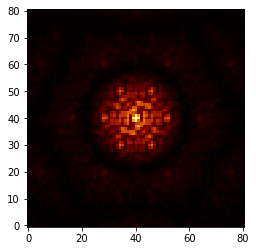

In [6]:
max_val = cube_t[0].max()
plt.imshow(cube_t[0], norm=PowerNorm(0.5, vmin=0, vmax=max_val), cmap="afmhot")
plt.show()

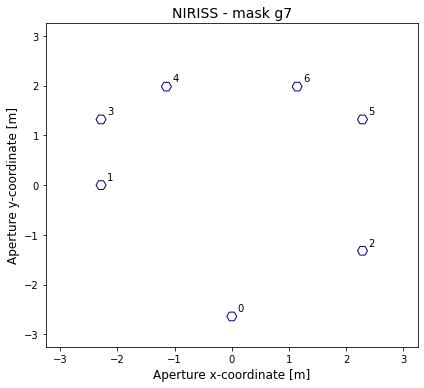

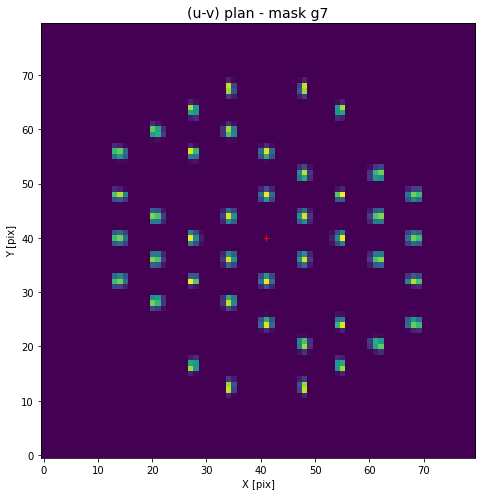

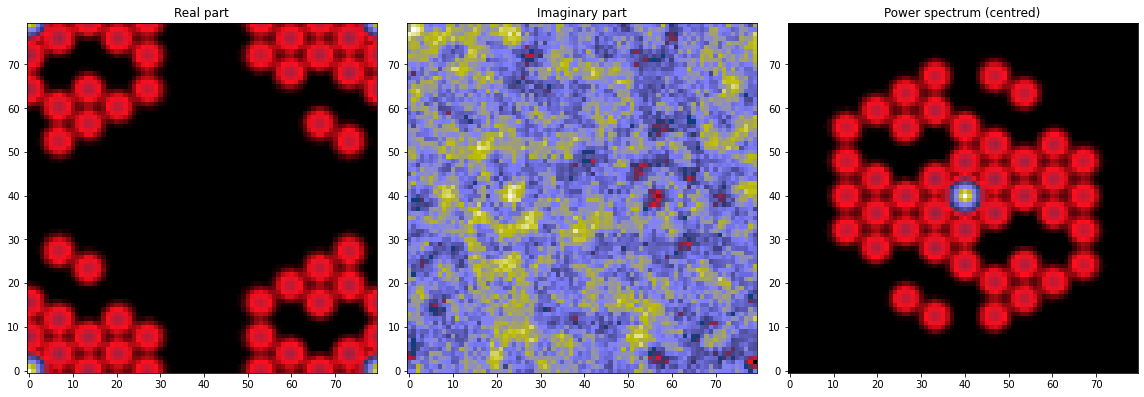

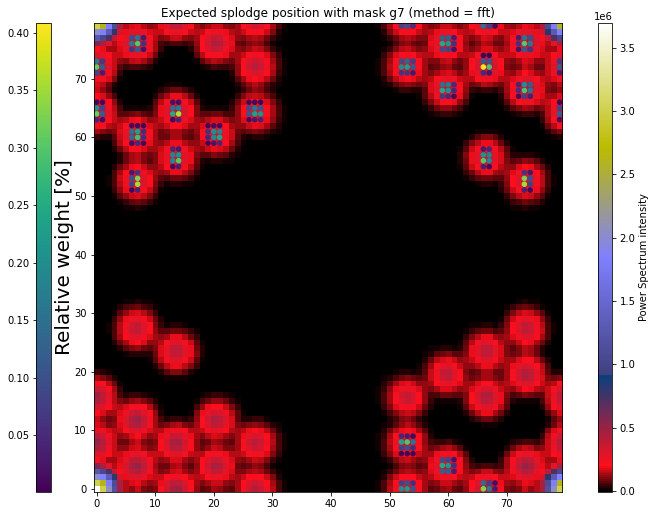

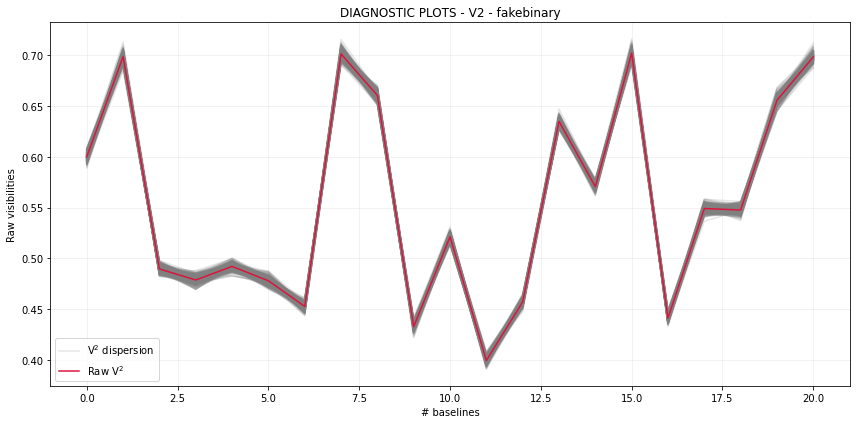

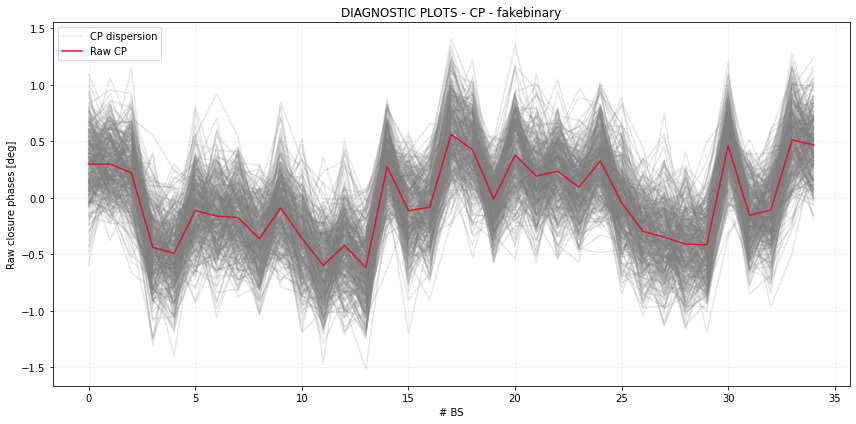

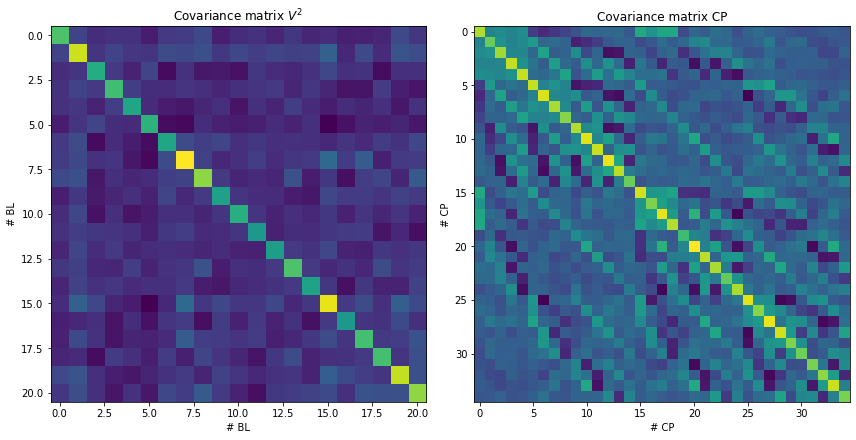

In [7]:
# Define extraction parameters
params_ami = {
    "peakmethod": "fft",
    "bs_multi_tri": False,
    "maskname": "g7",
    "fw_splodge": 0.7,
}

bs_t, bs_c, cal = extract_and_calib(cube_t, cube_c, params_ami)
plt.show()


 -- SHOW -- Inputs are classes from amical.calibrate:
-> (Check true_flag_v2, true_flag_t3 and snr parameters)



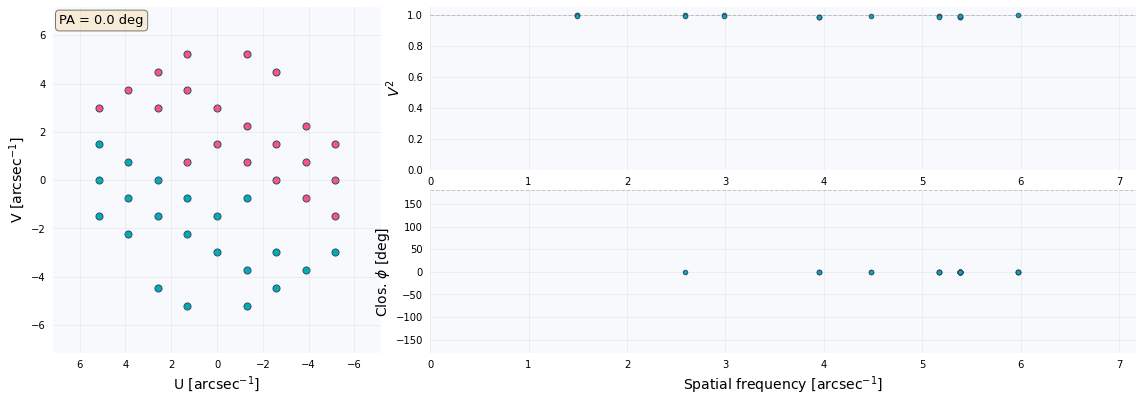

In [8]:
# Display the results as oifits
amical.show(cal)
plt.show()

## Cropped image
Now, crop the data to get a 35x35 image around the center. This is what we are limited to if we want a centered image with NIRISS primary dither.

In [9]:
# Cropping to 35, to match NIRISS primary dither limit
crop_size = 35
cube_t_crop = crop_cube(cube_t, crop_size)
cube_c_crop = crop_cube(cube_c, crop_size)

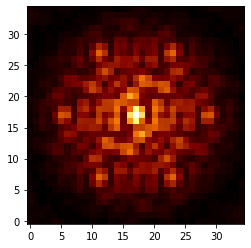

In [10]:
max_val = cube_t_crop[0].max()
plt.imshow(cube_t_crop[0], norm=PowerNorm(0.5, vmin=0, vmax=max_val), cmap="afmhot")
plt.show()

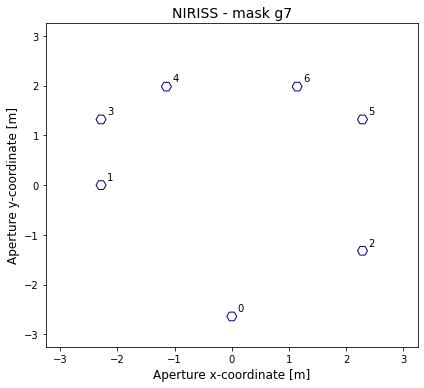

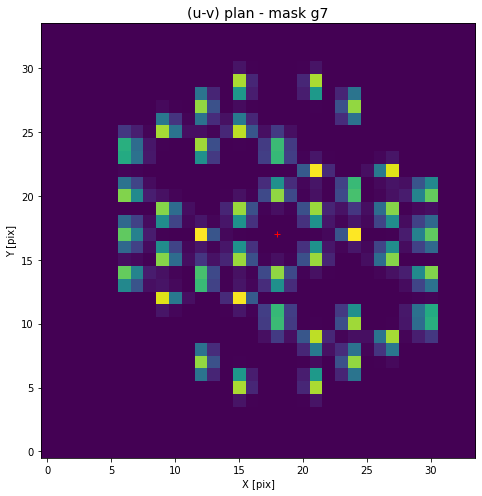

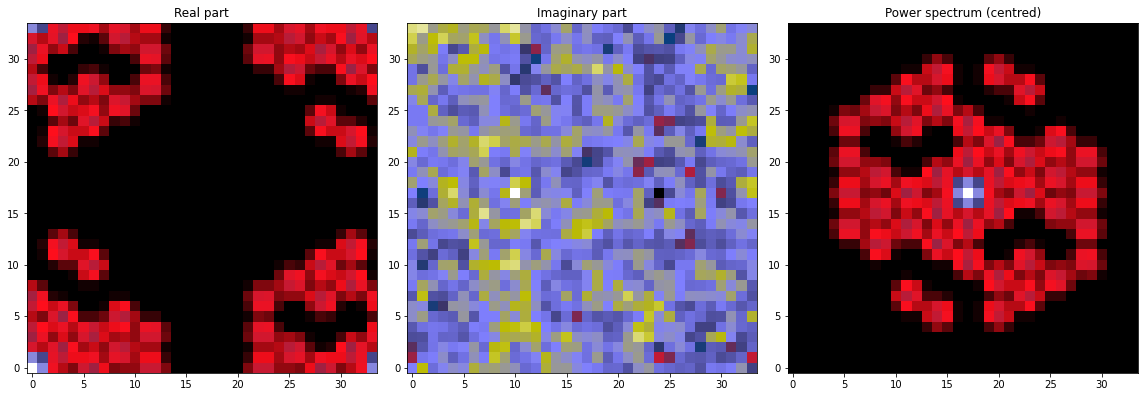

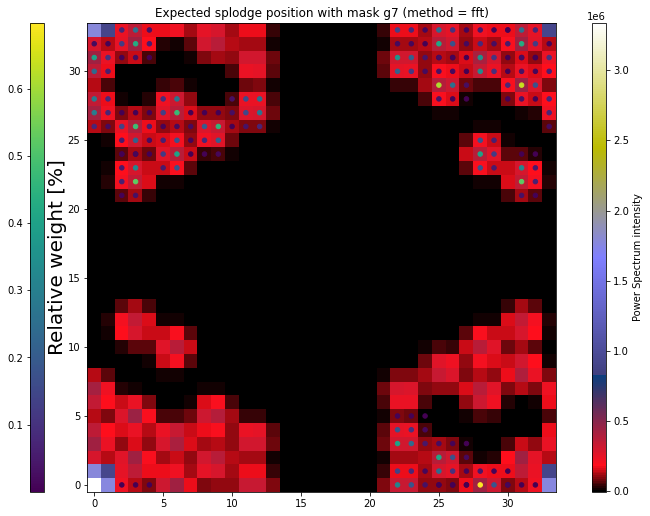

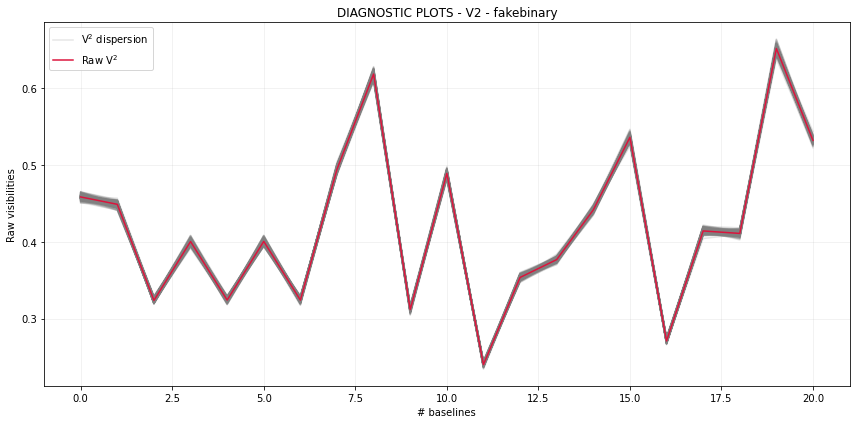

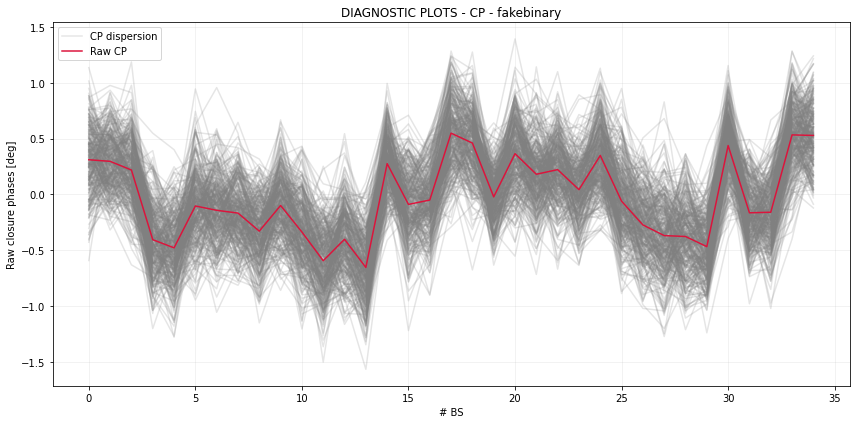

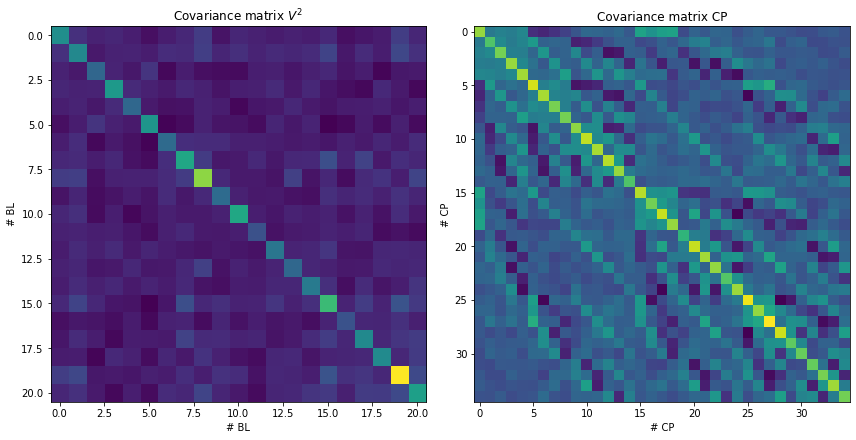

In [11]:
bs_t_crop, bs_c_crop, cal_crop = extract_and_calib(cube_t_crop, cube_c_crop, params_ami)
plt.show()


 -- SHOW -- Inputs are classes from amical.calibrate:
-> (Check true_flag_v2, true_flag_t3 and snr parameters)



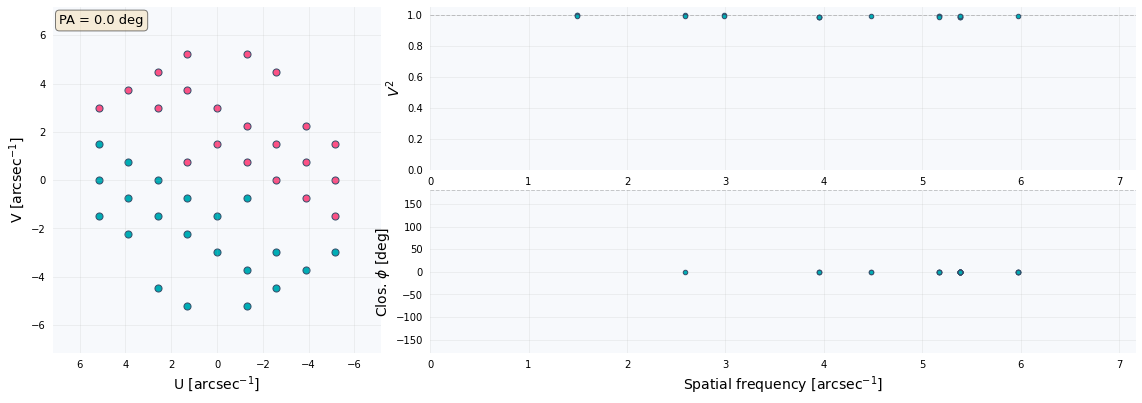

In [12]:
# Display the results as oifits
amical.show(cal_crop)
plt.show()

## Padded interferogram
Now, we take the cropped image and pad the image to get an 81x81 image. This should interpolate the cropped (lower resolution) image in the Fourier plane.

In [14]:
# Now, pad the cropped version
cube_t_pad = pad_cube(cube_t_crop, pad_to=cube_t.shape[1])
cube_c_pad = pad_cube(cube_c_crop, pad_to=cube_c.shape[1])

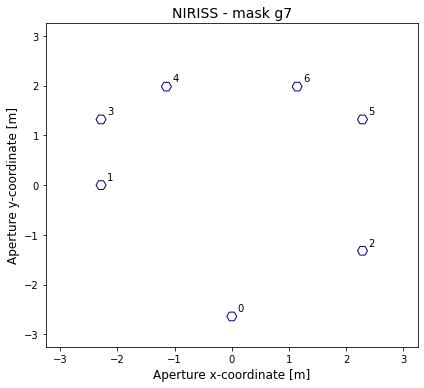

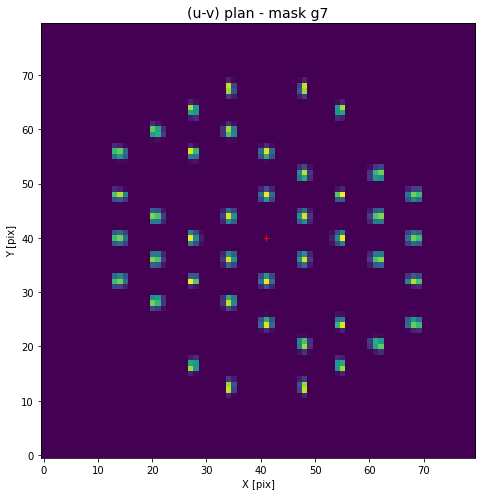

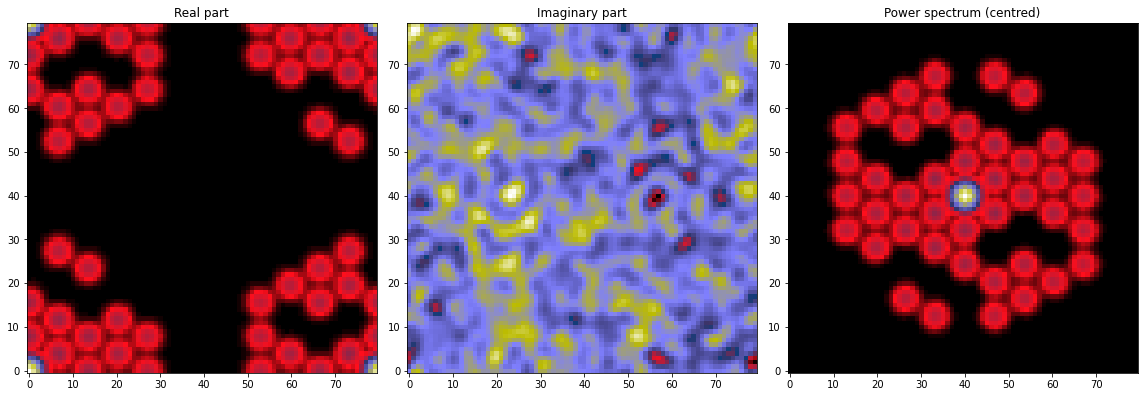

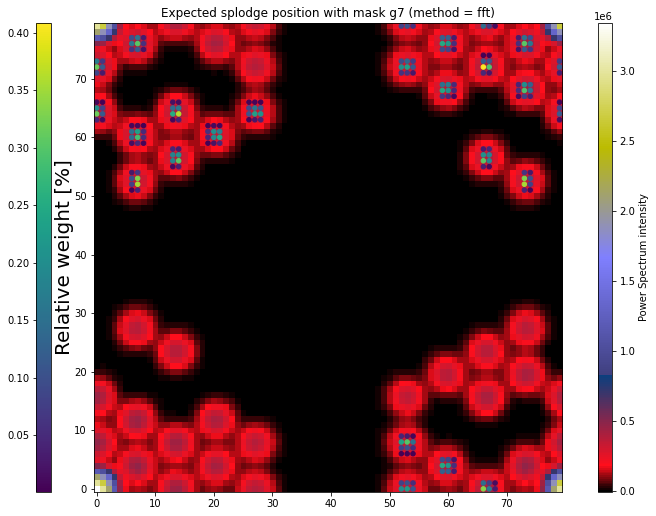

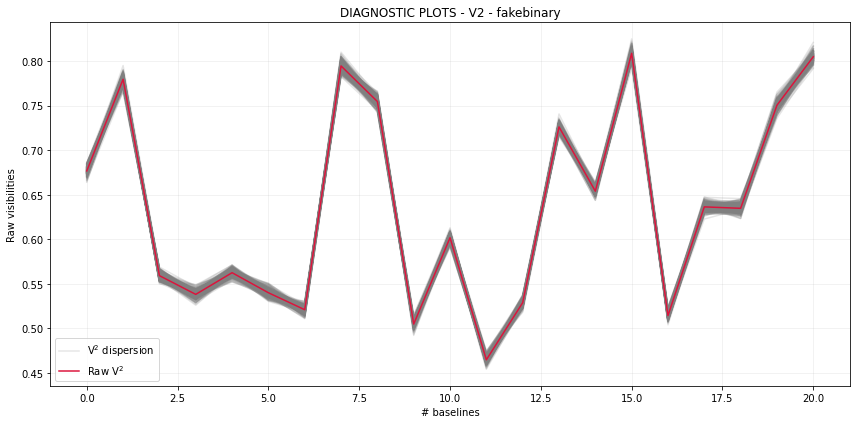

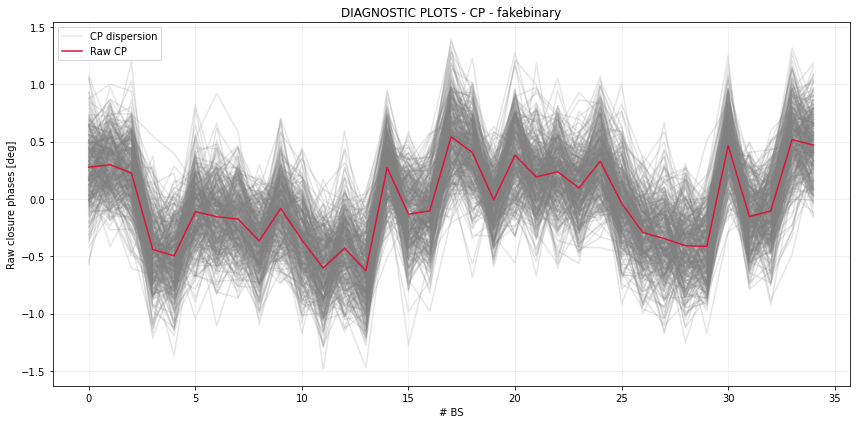

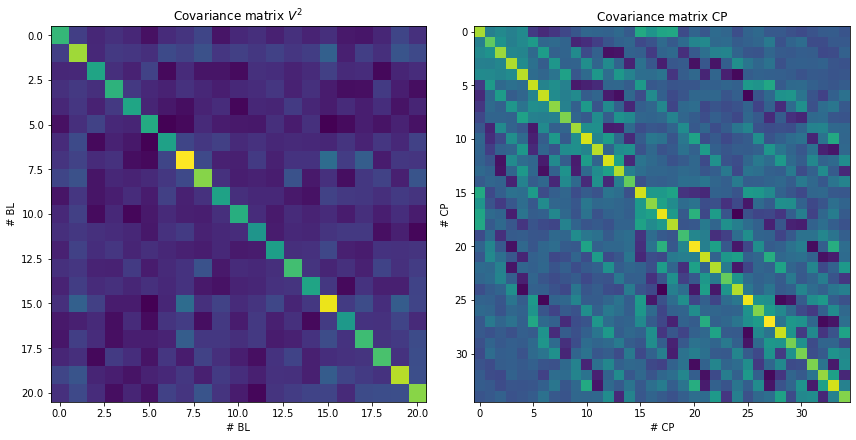

In [15]:
bs_t_pad, bs_c_pad, cal_pad = extract_and_calib(cube_t_pad, cube_c_pad, params_ami)
plt.show()


 -- SHOW -- Inputs are classes from amical.calibrate:
-> (Check true_flag_v2, true_flag_t3 and snr parameters)



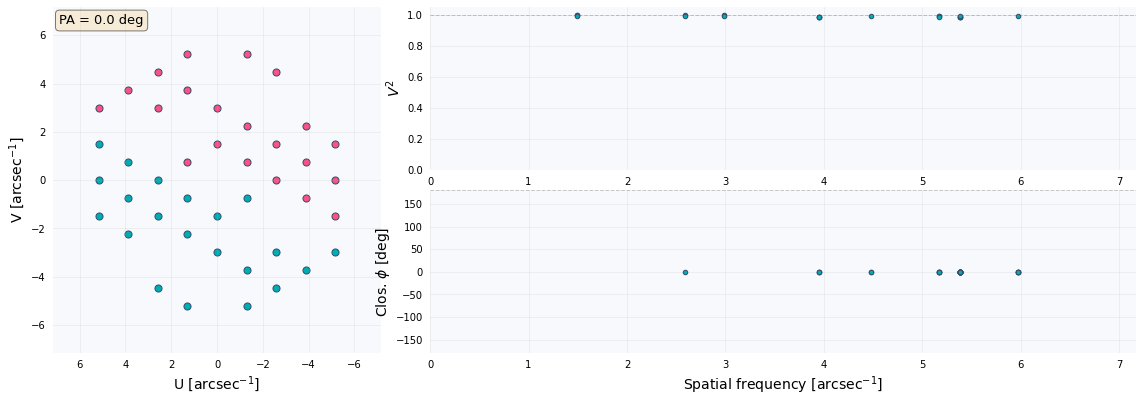

In [16]:
amical.show(cal_pad)
plt.show()

## Comparing the cropped, padded and original results
### Difference between the interferograms
First, we just take a quick look at how the PSFs differ (i.e. what do we loose by cropping). For NIRISS dithered data, the black square would be in the corner.

In [17]:
# Residuals between padded and original image
cube_t[0] - cube_t_pad[0]
cube_diff = cube_t - cube_t_pad

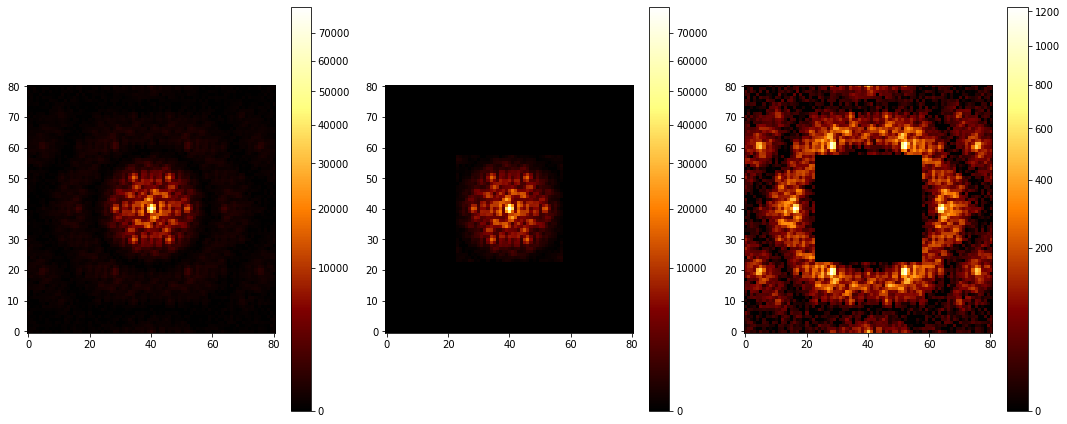

In [18]:
fig, axs = plt.subplots(ncols=3, figsize=(15, 6))
max_val = cube_t[0].max()
im = axs[0].imshow(cube_t[0], norm=PowerNorm(0.5, vmin=0, vmax=max_val), cmap="afmhot")
fig.colorbar(im, ax=axs[0])
im_pad = axs[1].imshow(cube_t_pad[0], norm=PowerNorm(0.5, vmin=0, vmax=max_val), cmap="afmhot")
fig.colorbar(im_pad, ax=axs[1])
max_val = cube_diff[0].max()
im_diff = axs[2].imshow(cube_diff[0], norm=PowerNorm(0.5, vmin=0, vmax=max_val), cmap="afmhot")
fig.colorbar(im_diff, ax=axs[2])
plt.tight_layout()
plt.show()

In [21]:
def plot_comparison(bs1, bs2, label1, label2, qty="vis2"):
    if qty == "vis2":
        qty_arr = "v2_arr"
    else:
        qty_arr = qty + "_arr"
    fig, axs = plt.subplots(nrows=2, figsize=(10, 10))
    axs[0].errorbar(np.arange(bs1[qty].size), bs1[qty], yerr=bs1["e_"+qty], fmt="k.", capsize=2, label=label1)
    axs[0].errorbar(np.arange(bs2[qty].size), bs2[qty], yerr=bs2["e_"+qty], fmt="b.", capsize=2, label=label2)
    axs[0].plot(bs1.matrix[qty_arr].T, ".", alpha=0.02, color="C0")
    axs[0].plot(bs2.matrix[qty_arr].T, ".", alpha=0.02, color="C0")
    axs[0].set_ylabel(qty)
    axs[0].legend()
    qty_diff = bs1[qty] - bs2[qty]
    axs[1].errorbar(np.arange(bs1[qty].size), qty_diff, yerr=bs1["e_"+qty], fmt="k.", capsize=2)
    axs[1].plot(bs1.matrix[qty_arr].T - bs2.matrix[qty_arr].T, ".", alpha=0.02, color="C0")

    print(f"Residual RMS ({label1} - {label2}): {np.std(qty_diff):.4f}")
    return fig, axs

### Comparing Raw observables
Now, we compare V2 and CP values of the various cases

V2 comparison
Residual RMS (Original file - Cropped and Padded file): 0.0132


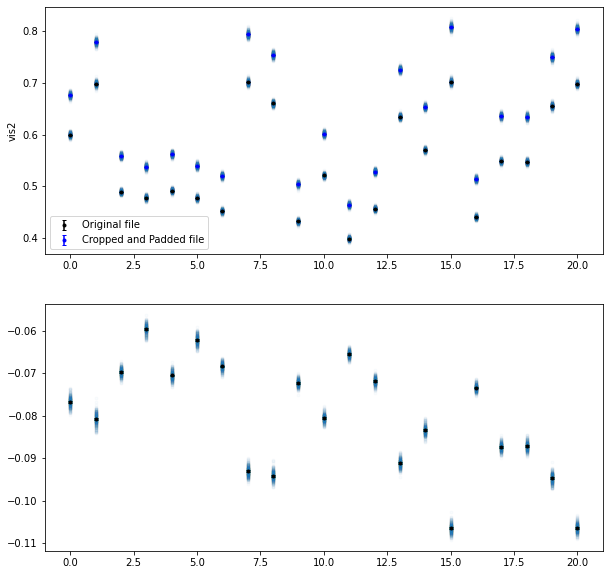

In [22]:
print("V2 comparison")
plot_comparison(bs_t, bs_t_pad, "Original file", "Cropped and Padded file", qty="vis2")
plt.show()

Residual RMS (Original file - Cropped file): 0.0631


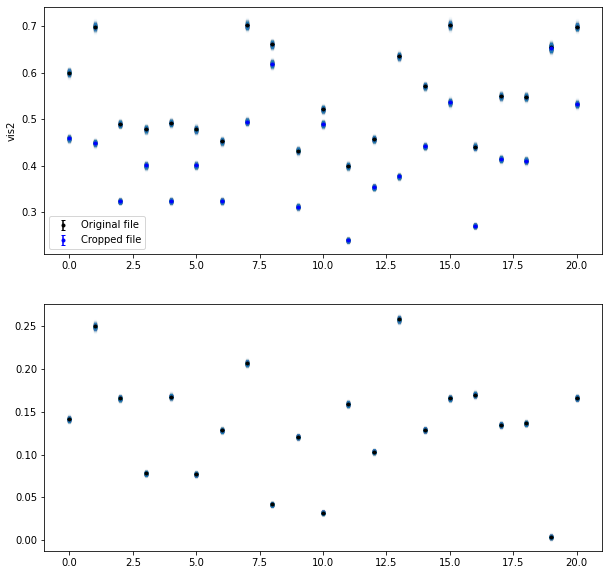

In [23]:
plot_comparison(bs_t, bs_t_crop, "Original file", "Cropped file", qty="vis2")
plt.show()

Residual RMS (Cropped file - Cropped and padded file): 0.0661


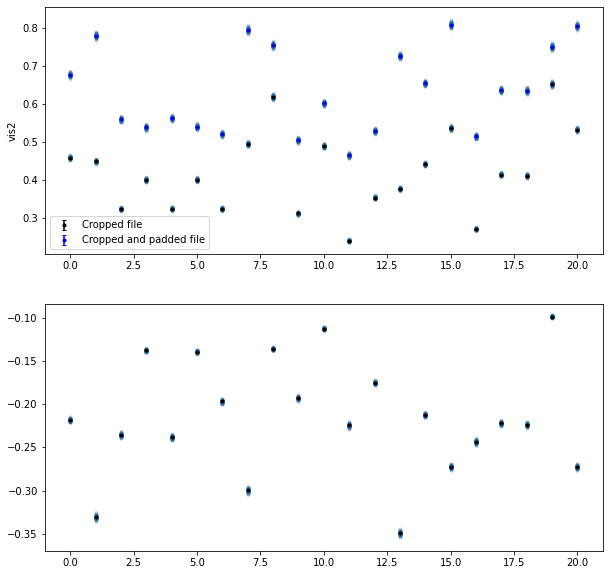

In [24]:
plot_comparison(bs_t_crop, bs_t_pad, "Cropped file", "Cropped and padded file", qty="vis2")
plt.show()

**As we see above, the padded file shows smaller, although still significant, difference with the original file**

CP comparison
Residual RMS (Original file - Cropped and Padded file): 0.0081


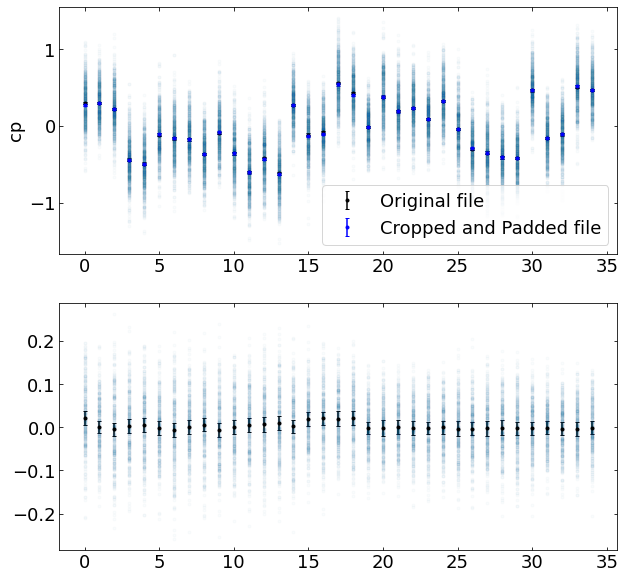

In [107]:
print("CP comparison")
plot_comparison(bs_t, bs_t_pad, "Original file", "Cropped and Padded file", qty="cp")
plt.show()

Residual RMS (Original file - Cropped file): 0.0263


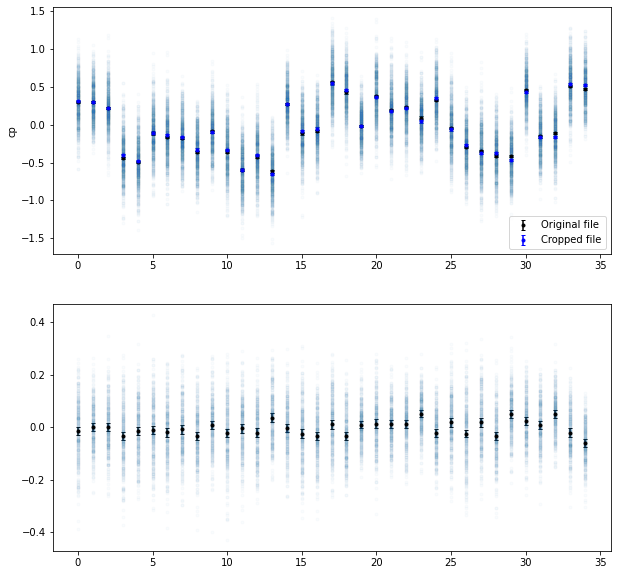

In [26]:
plot_comparison(bs_t, bs_t_crop, "Original file", "Cropped file", qty="cp")
plt.show()

Residual RMS (Cropped file - Cropped and padded file): 0.0296


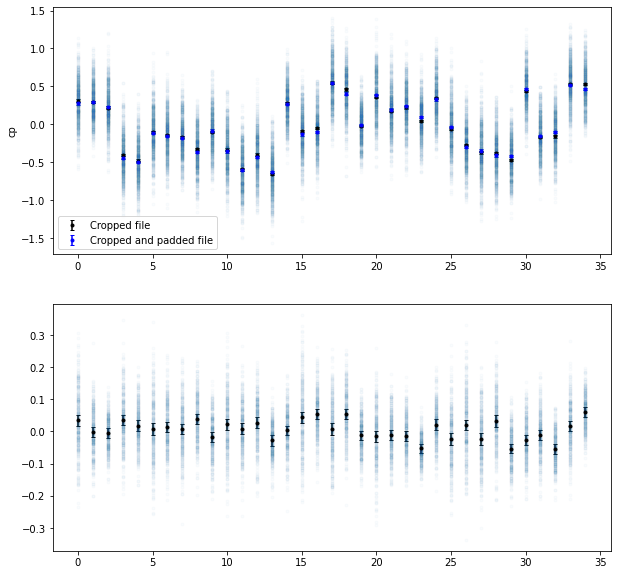

In [27]:
plot_comparison(bs_t_crop, bs_t_pad, "Cropped file", "Cropped and padded file", qty="cp")
plt.show()

**For the CP, the difference is mostly consistent with 0. However, the padded images still appears slightly closer to the original result**
### Covariance Matrices
We can also take a quick look at the covariance of V2 and CP to see if the cropping as an effect.

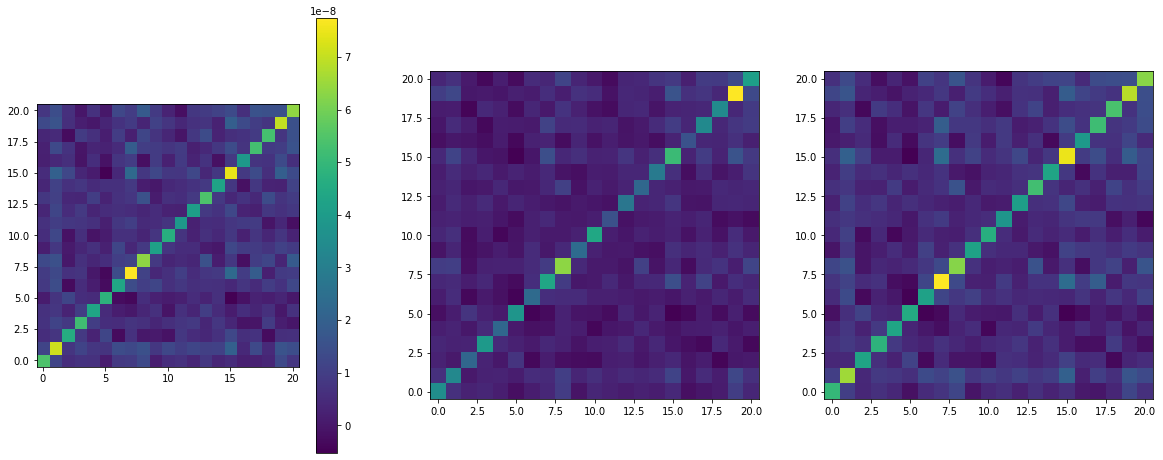

In [28]:
fig, axs = plt.subplots(ncols=3, figsize=(20, 8))
axs[0].imshow(bs_t.matrix.v2_cov)
axs[1].imshow(bs_t_crop.matrix.v2_cov)
im = axs[2].imshow(bs_t_pad.matrix.v2_cov)
fig.colorbar(im, ax=axs[0])
plt.show()

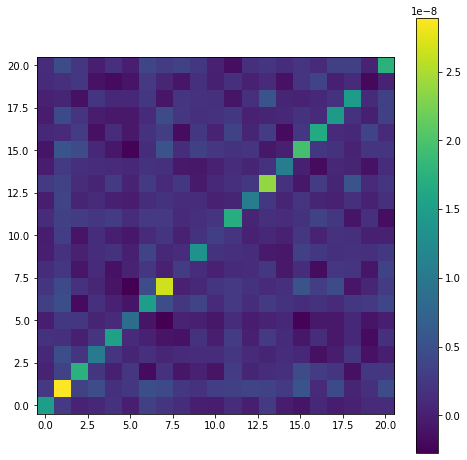

In [29]:
plt.figure(figsize=(8, 8))
plt.imshow(bs_t.matrix.v2_cov - bs_t_crop.matrix.v2_cov)
plt.colorbar()
plt.show()

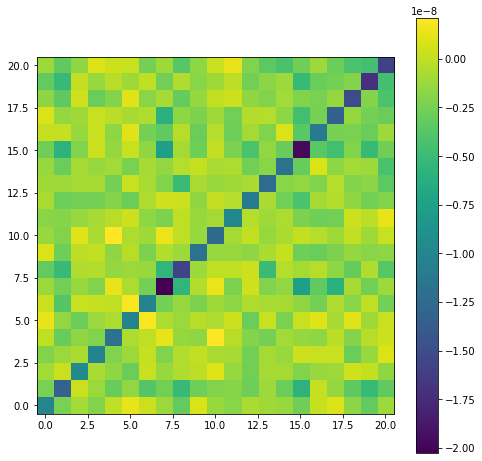

In [30]:
plt.figure(figsize=(8, 8))
plt.imshow(bs_t.matrix.v2_cov - bs_t_pad.matrix.v2_cov)
plt.colorbar()
plt.show()

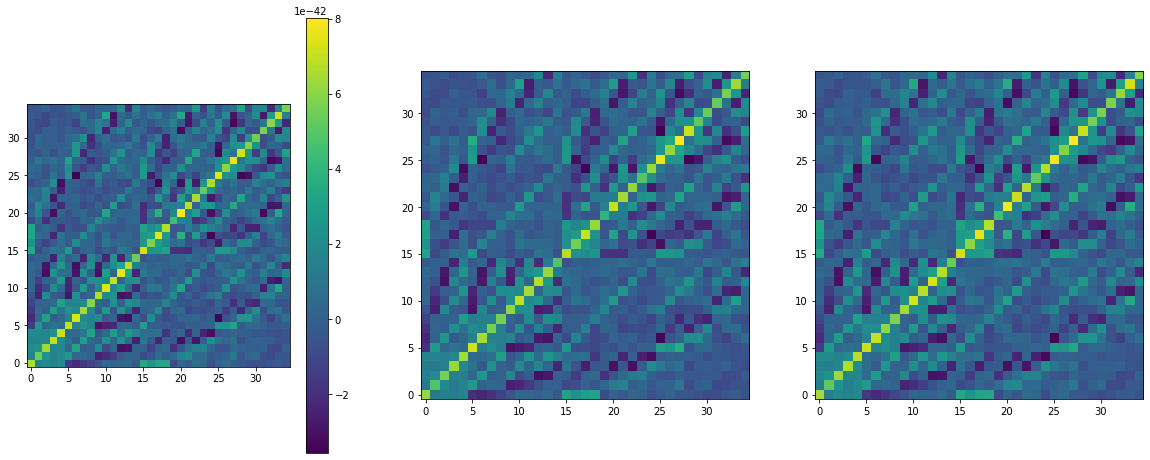

In [31]:
fig, axs = plt.subplots(ncols=3, figsize=(20, 8))
axs[0].imshow(bs_t.matrix.cp_cov)
axs[1].imshow(bs_t_crop.matrix.cp_cov)
im = axs[2].imshow(bs_t_pad.matrix.cp_cov)
fig.colorbar(im, ax=axs[0])
plt.show()

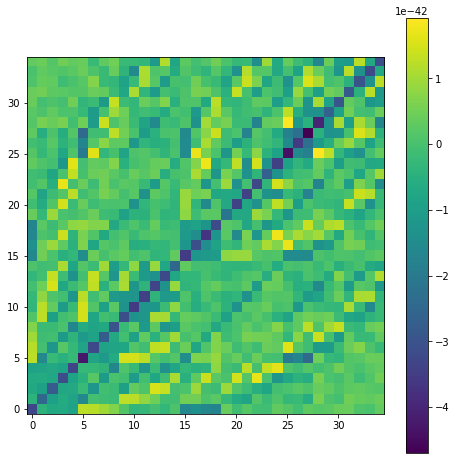

In [32]:
plt.figure(figsize=(8, 8))
plt.imshow(bs_t.matrix.cp_cov - bs_t_crop.matrix.cp_cov)
plt.colorbar()
plt.show()

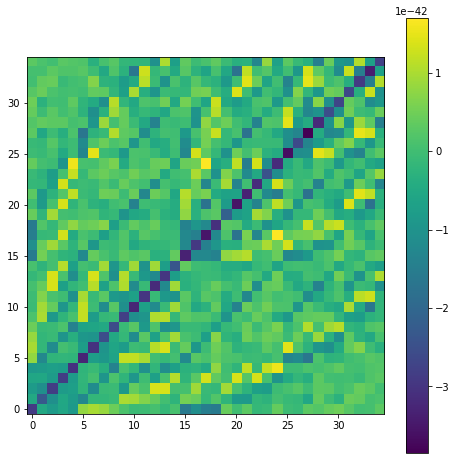

In [33]:
plt.figure(figsize=(8, 8))
plt.imshow(bs_t.matrix.cp_cov - bs_t_pad.matrix.cp_cov)
plt.colorbar()
plt.show()

### Calibrated observables
The calibrated will also undergo the same cropping and/or padding as the target. And what we analyse in the end is the calibrated result. So we can compare look at:
- How do the calibrated residuals compare ?
- How does the error on V2 and CP compare when we crop and/or pad the data ?

In [47]:
def compare_calibrated(cal1, cal2, label1, label2):
    fig, axs = plt.subplots(nrows=2, figsize=(10, 10))
    axs[0].errorbar(np.arange(cal1.vis2.size), cal1.vis2 - cal2.vis2, yerr=np.sqrt(cal1.e_vis2**2 + cal2.e_vis2**2), fmt="ko", capsize=2)
    axs[0].set_ylabel("V2")
    axs[0].set_xlabel("# Baseline")
    axs[1].errorbar(np.arange(cal1.cp.size), cal1.cp - cal2.cp, yerr=np.sqrt(cal1.e_cp**2 + cal2.e_cp**2), fmt="ko", capsize=2)
    axs[1].set_ylabel("CP")
    axs[1].set_xlabel("# BS")
    
    print(f"{label1} vs {label2}")
    print(f"V2 Residual", np.std(cal1.vis2 - cal2.vis2))
    print(f"CP Residual", np.std(cal1.cp - cal2.cp))
    print(f"V2 mean error ratio", np.mean(cal1.e_vis2 / cal2.e_vis2))
    print(f"CP mean error ratio", np.mean(cal1.e_cp / cal2.e_cp))

    return fig, axs

Original vs Cropped
V2 Residual 0.0002146181998707172
CP Residual 0.008173001328070086
V2 mean error ratio 0.96248286040167
CP mean error ratio 0.9724188013498686


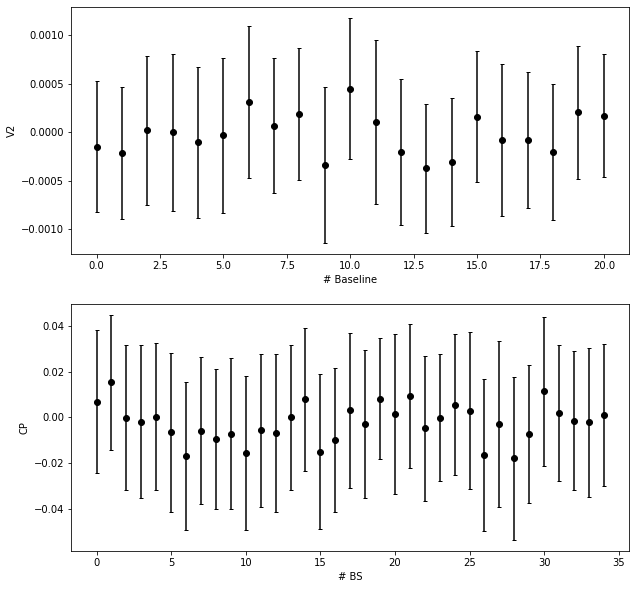

Original vs Padded
V2 Residual 0.0001623072851280016
CP Residual 0.004938095832825765
V2 mean error ratio 0.9915432440522766
CP mean error ratio 0.9965810556557565


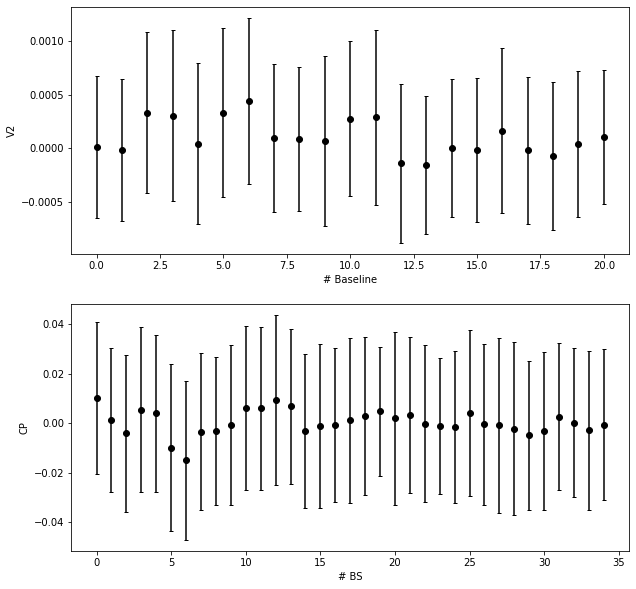

In [50]:
compare_calibrated(cal, cal_crop, "Original", "Cropped")
plt.show()

compare_calibrated(cal, cal_pad, "Original", "Padded")
plt.show()

## Comparing CANDID Fits
We can also do a quick fit with CANDID to see if the results differ.

In [52]:
# First we need to save the calibrated data
_ = amical.save(cal, oifits_file="example_original.oifits")
_ = amical.save(cal_crop, oifits_file="example_crop.oifits")
_ = amical.save(cal_pad, oifits_file="example_pad.oifits")

/home/vandal/astro/ami/venv/lib64/python3.10/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): 'fakebinary': No known catalog could be found
  warnings.warn("Warning: The script line number %i raised "
/home/vandal/astro/ami/venv/lib64/python3.10/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): 'fakebinary': No known catalog could be found
  warnings.warn("Warning: The script line number %i raised "
/home/vandal/astro/ami/venv/lib64/python3.10/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): 'fakebinary': No known catalog could be found
  warnings.warn("Warning: The script line number %i raised "


In [57]:
def candid_fit(path, params):
    

    fit1 = amical.candid_grid(
        path, **param_candid, diam=20, doNotFit=[], save=False
    )
    
    # Plot and save the fitted model
    amical.plot_model(path, fit1["best"], save=False)

    cr_candid = amical.candid_cr_limit(
        path, **param_candid, fitComp=fit1["comp"], save=False
    )
        
    return fit1, cr_candid

In [58]:
param_candid = {
        "rmin": 20,  # inner radius of the grid
        "rmax": 250,  # outer radius of the grid
        "step": 50,  # grid sampling
        "ncore": 1,  # core for multiprocessing
    }

### Fitting the original results

 | --- Start CANDID fitting --- :
 | loading file Saveoifits/example_original.oifits
 | observables available: [ 't3', 'v2', 'cp']
 | instruments: [ 'NIRISS']
 | best fit diameter (UD): 13.433 +- 1.171 mas (χ2 = 191.346)
 | Grid Fitting on 74 starting points (single processor) ... (it should take about 0 seconds)
 [====================================================        ] 87%,     0 s (remaining)
 | Grid of fit took 1.7 seconds
 | current grid step (50.00mas) is too fine!!! --> 100.00mas should be enough


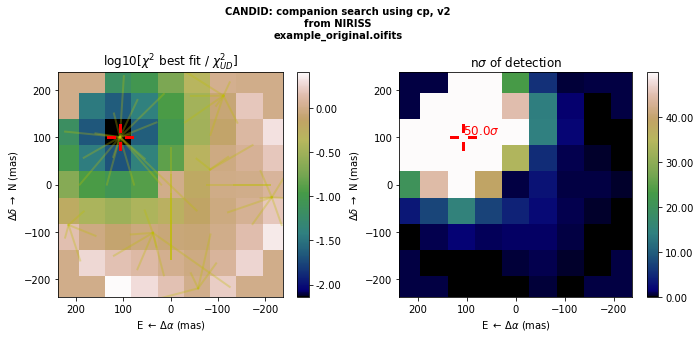


Results binary fit (χ2 = 1.1, nσ = 50.0):
-------------------
Sep = 147.1 +/- 0.7 mas
Theta = 46.9 +/- 0.3 deg
CR = 247.1 +/- 2.5
dm = 5.98 +/- 0.01
 | --- Start CANDID contrast limit --- :
 | loading file Saveoifits/example_original.oifits
 | observables available: [ 't3', 'v2', 'cp']
 | instruments: [ 'NIRISS']
 | observables: ['cp', 'v2'] from ['t3', 'v2', 'cp']
 | instruments: ['NIRISS'] from ['NIRISS']
 | best fit diameter (UD): 2.218 +- 0.517 mas (χ2 = 1.034)
 | Detection Limit Map 10x10 (single processor) ... it should take about 7 seconds
 | Method: injection
 [============================================================] 100%,     0 s (remaining)


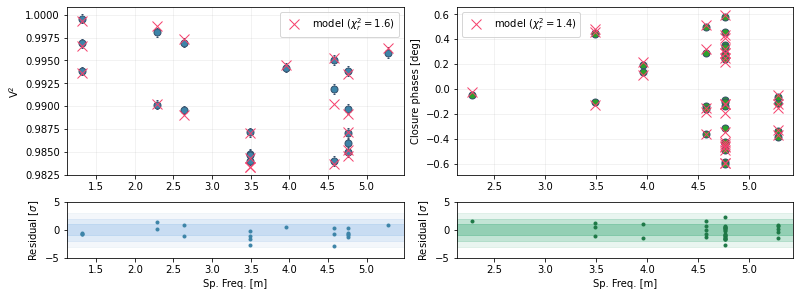

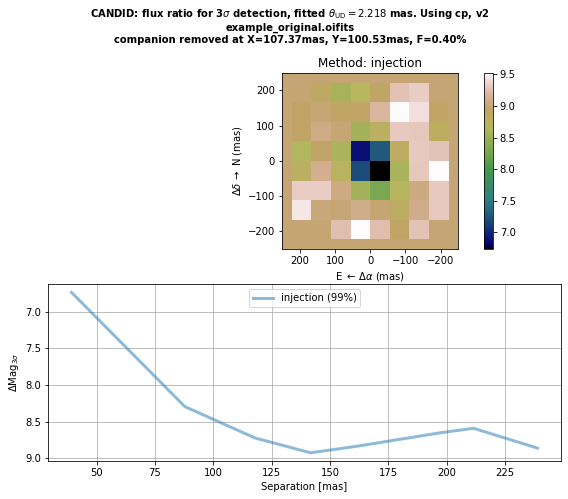

In [59]:
fit, cr = candid_fit("Saveoifits/example_original.oifits", param_candid)

 | --- Start CANDID fitting --- :
 | loading file Saveoifits/example_crop.oifits
 | observables available: [ 't3', 'v2', 'cp']
 | instruments: [ 'NIRISS']
 | best fit diameter (UD): 13.426 +- 1.167 mas (χ2 = 175.240)
 | Grid Fitting on 74 starting points (single processor) ... (it should take about 0 seconds)
 [====================================================        ] 87%,     0 s (remaining)
 | Grid of fit took 1.7 seconds
 | current grid step (50.00mas) is too fine!!! --> 100.00mas should be enough


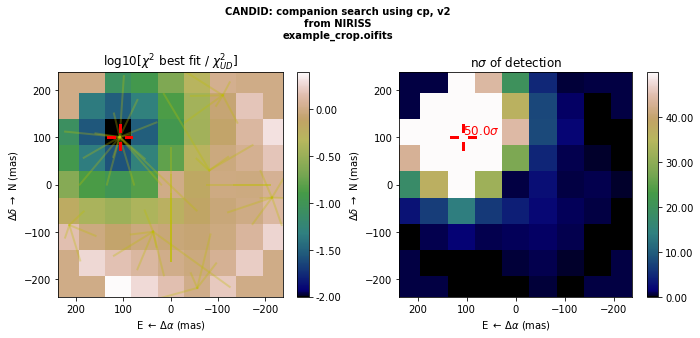


Results binary fit (χ2 = 1.4, nσ = 50.0):
-------------------
Sep = 147.5 +/- 0.8 mas
Theta = 47.0 +/- 0.3 deg
CR = 250.7 +/- 3.0
dm = 6.00 +/- 0.01
 | --- Start CANDID contrast limit --- :
 | loading file Saveoifits/example_crop.oifits
 | observables available: [ 't3', 'v2', 'cp']
 | instruments: [ 'NIRISS']
 | observables: ['cp', 'v2'] from ['t3', 'v2', 'cp']
 | instruments: ['NIRISS'] from ['NIRISS']
 | best fit diameter (UD): 2.691 +- 0.499 mas (χ2 = 1.318)
 | Detection Limit Map 10x10 (single processor) ... it should take about 3 seconds
 | Method: injection
 [============================================================] 100%,     0 s (remaining)


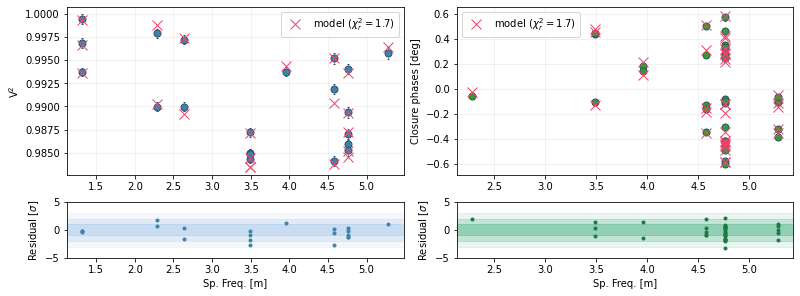

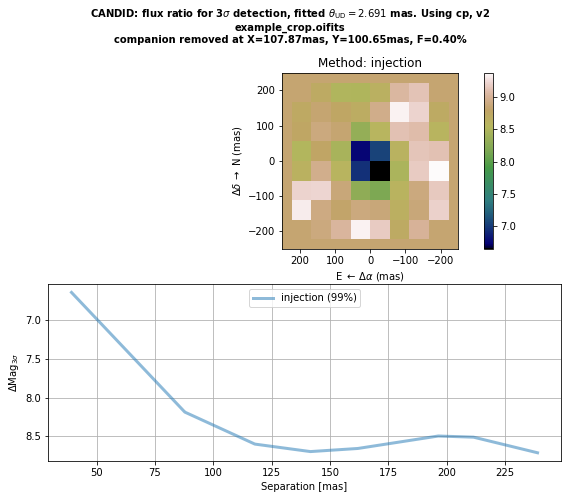

In [61]:
fit_crop, cr_crop = candid_fit("Saveoifits/example_crop.oifits", param_candid)

 | --- Start CANDID fitting --- :
 | loading file Saveoifits/example_pad.oifits
 | observables available: [ 't3', 'v2', 'cp']
 | instruments: [ 'NIRISS']
 | best fit diameter (UD): 13.508 +- 1.168 mas (χ2 = 189.877)
 | Grid Fitting on 74 starting points (single processor) ... (it should take about 0 seconds)
 [====================================================        ] 87%,     0 s (remaining)
 | Grid of fit took 1.7 seconds
 | current grid step (50.00mas) is too fine!!! --> 100.00mas should be enough


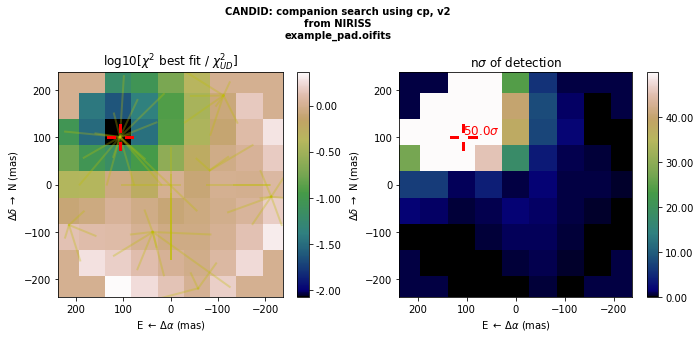


Results binary fit (χ2 = 1.3, nσ = 50.0):
-------------------
Sep = 147.2 +/- 0.8 mas
Theta = 46.8 +/- 0.3 deg
CR = 247.2 +/- 2.8
dm = 5.98 +/- 0.01
 | --- Start CANDID contrast limit --- :
 | loading file Saveoifits/example_pad.oifits
 | observables available: [ 't3', 'v2', 'cp']
 | instruments: [ 'NIRISS']
 | observables: ['cp', 'v2'] from ['t3', 'v2', 'cp']
 | instruments: ['NIRISS'] from ['NIRISS']
 | best fit diameter (UD): 2.734 +- 0.458 mas (χ2 = 1.225)
 | Detection Limit Map 10x10 (single processor) ... it should take about 4 seconds
 | Method: injection
 [============================================================] 100%,     0 s (remaining)


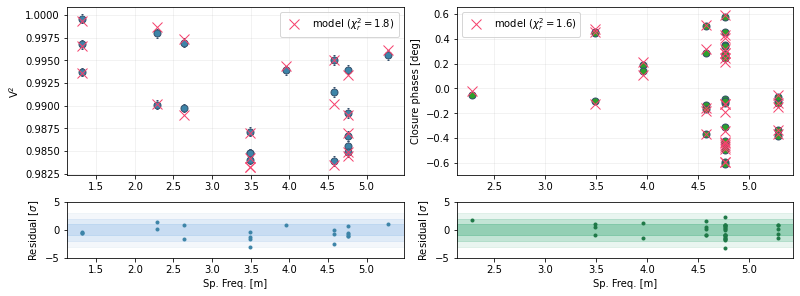

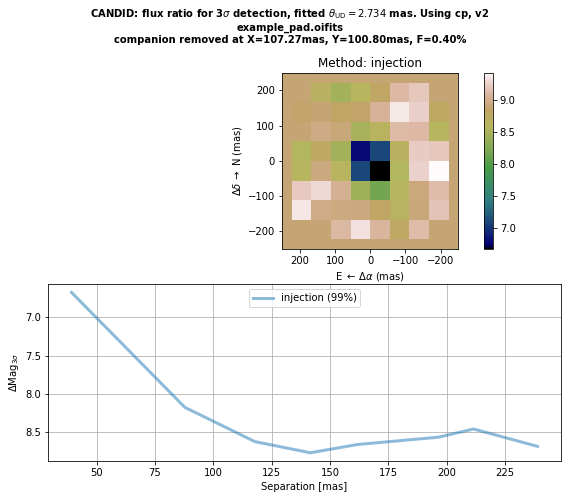

In [60]:
fit_pad, cr_pad = candid_fit("Saveoifits/example_pad.oifits", param_candid)

In [75]:
my_ticks = ["Original", "Cropped", "Padded"]
fits = [fit, fit_crop, fit_pad]
fit_dict = dict(zip(my_ticks, fit_list))

In [84]:
dms = [f["best"]["dm"] for f in fits]
dms_err = [f["uncer"]["dm"] for f in fits]

pas = [f["best"]["theta"] for f in fits]
pas_err = [f["uncer"]["theta"] for f in fits]

seps = [f["best"]["sep"] for f in fits]
seps_err = [f["uncer"]["sep"] for f in fits]

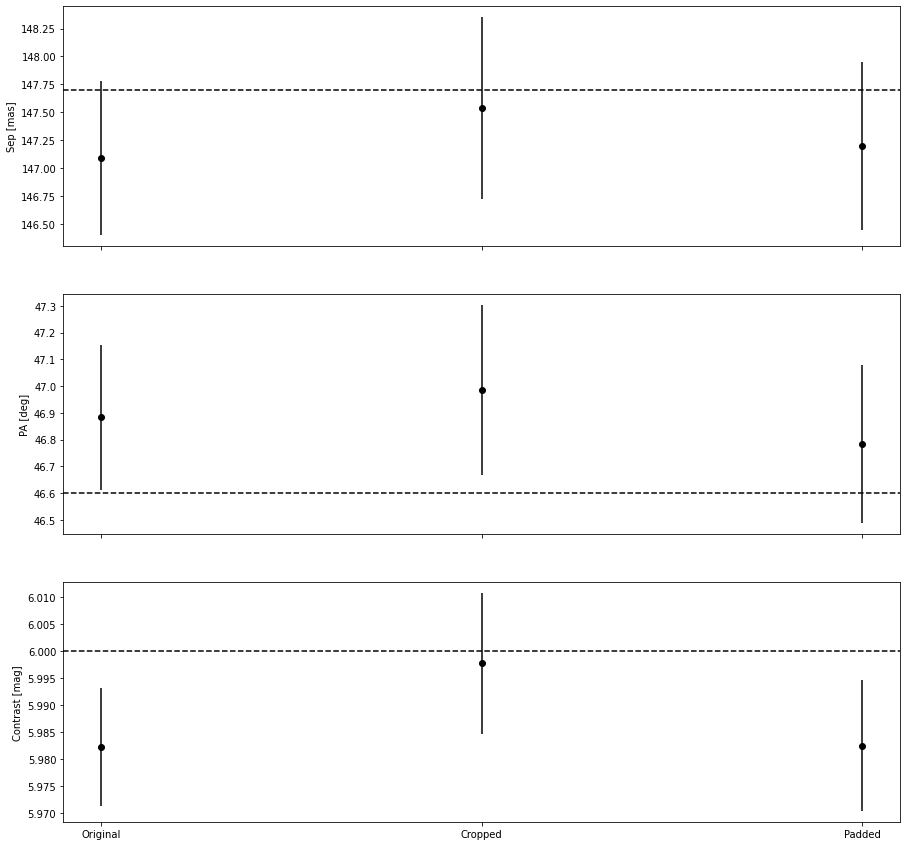

In [97]:
fig, (ax1,ax2,ax3) = plt.subplots(3,1,figsize=(15,15),sharex=True)
ax1.errorbar(np.arange(len(seps)), seps, yerr=seps_err, fmt="ko")
ax1.set_ylabel("Sep [mas]")
ax1.axhline(sep_true, linestyle="--", color="k")

ax2.errorbar(np.arange(len(pas)), pas, yerr=pas_err, fmt="ko")
ax2.set_ylabel("PA [deg]")
ax2.axhline(pa_true, linestyle="--", color="k")

ax3.errorbar(np.arange(len(dms)), dms, yerr=dms_err, fmt="ko")
ax3.set_ylabel("Contrast [mag]")
ax3.axhline(dm_true, linestyle="--", color="k")

ax3.set_xticks(np.arange(len(dms)))
ax3.set_xticklabels(my_ticks)
plt.show()

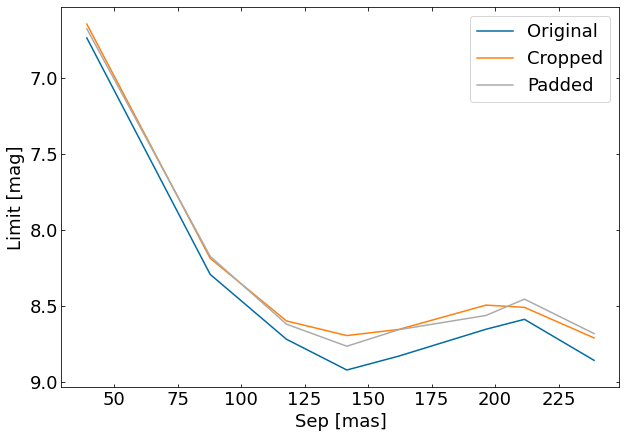

In [114]:
cr_dict = dict(zip(my_ticks, [cr, cr_crop, cr_pad]))

plt.figure(figsize=(10, 7))
for lab, c in cr_dict.items():
    plt.plot(c["r"], c["cr_limit"], label=lab)
plt.xlabel("Sep [mas]")
plt.ylabel("Limit [mag]")
plt.gca().invert_yaxis()
plt.legend()
plt.show()